# How to optimize QAOA to run Max-Cut on Hardware

There are several strategies that can help squeeze out the best performance when running QAOA on real hadware. This notebook will walk you through the QAOA workflow and showcase how it can be optimized for a particular execution of **Max-Cut**.

## Pre-Requisites

The starting point of the workflow is a problem definition, in the form of a **graph** or **problem hamiltonian**.
In this example, we will import a pre-computed graph from a json file, for which we want to find the cut that maximizes the number of crossing edges. Having the problem in graph-form will allow us to directly apply SAT-mapping (see step 2).

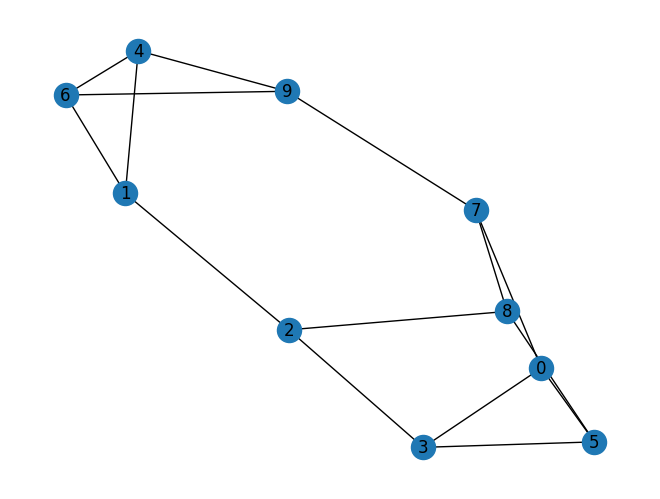

In [1]:
import json
import networkx as nx

graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))
graph = nx.from_edgelist(data["Original graph"])
nx.draw(graph, with_labels=True)

This graph has 10 nodes and 15 edges, and it can be encoded in 10 qubits.

In [2]:
num_qubits = len(graph.nodes)
print(num_qubits)

10


The graph utils included in this repository allow you to easily switch between the max-cut graph and problem hamiltonian.

[('IIZIIIIIIZ', 1.0), ('IIIIIIZIIZ', 1.0), ('IIIIZIIIIZ', 1.0), ('ZIZIIIIIII', 1.0), ('IZZIIIIIII', 1.0), ('IIIIIIZZII', 1.0), ('IIIIZIZIII', 1.0), ('IZIIZIIIII', 1.0), ('ZIIIIZIIII', 1.0), ('ZIIZIIIIII', 1.0), ('IZIIIIIZII', 1.0), ('IIIIIIIZZI', 1.0), ('IIIIIZIIZI', 1.0), ('IIIZIIIIZI', 1.0), ('IIIZIZIIII', 1.0)]


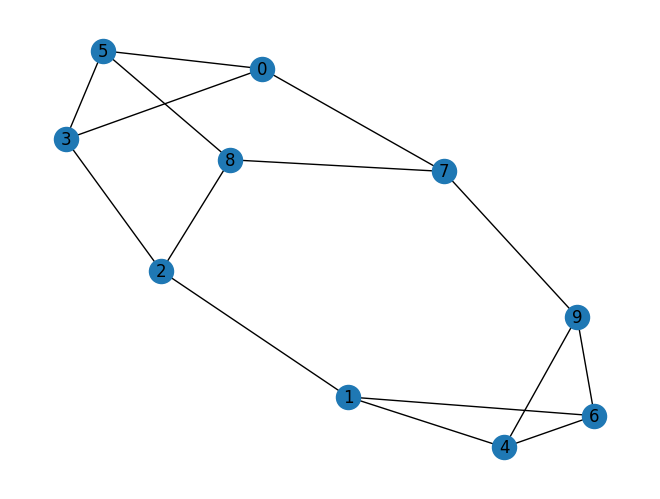

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis, build_max_cut_graph

original_hamiltonian = build_max_cut_paulis(graph)
print(original_hamiltonian)

original_graph = build_max_cut_graph(original_hamiltonian)
nx.draw(original_graph, with_labels=True)

## 1. Choose SWAP strategy

SWAP gate insertion is the technique of choice for most quantum circuits to run on quantum hardware with limited qubit connectivity.  The first couple of steps of the workflow depend on the choice of qubit configuration we want, which will determine the kind of SWAP strategy that will be used, as well as the evaluation criteria for the backend to obtain the best subset of qubits.

In this example, we choose a swap insertion strategy for blocks of commuting two-qubit gates which applies layers of SWAP gates simultaneously executable on the coupling map. This strategy is exposed as a standardized Qiskit transpiler pass, where we can choose different qubit configurations, in this case, a line.

In [4]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])

## 2. Remap graph using SAT mapper

Even when a circuit consists of commuting gates (this is the case for the QAOA circuit, but also for trotterized simulations of Ising Hamiltonians), finding a good initial mapping is a hard problem. The SAT-based approach presented in [Matsuo et al.](https://arxiv.org/abs/2212.05666) allows to find good initial mappings for circuits with commuting gates, which lead to a reduced number of swap layers.

This repository exposes the mapper class from Matsuo et al. (`SATMapper`) and adds the `remap_graph_with_sat` method that allows to remap the graph to a better initial state for a specific swap strategy.

Map from old to new edges:  {0: 6, 1: 2, 2: 7, 3: 8, 4: 3, 5: 9, 6: 1, 7: 5, 8: 4, 9: 0}
Min SAT layers: 2


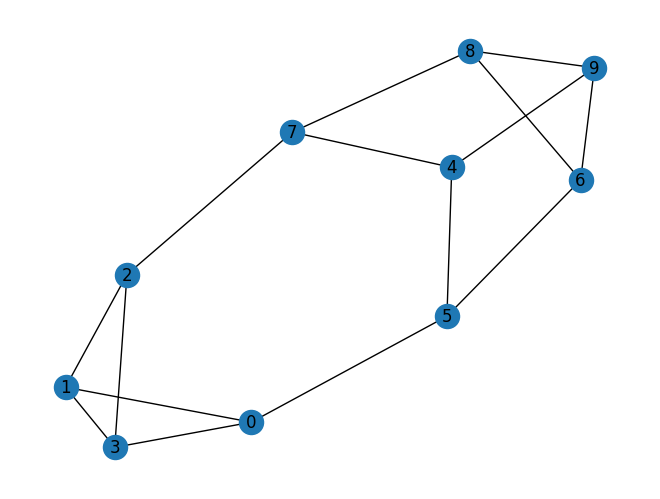

In [5]:
from qopt_best_practices.sat_mapping import SATMapper

sm = SATMapper()
remapped_g, sat_map, min_sat_layers = sm.remap_graph_with_sat(
    graph=graph, swap_strategy=swap_strategy
)

print("Map from old to new edges: ", sat_map)
print("Min SAT layers:", min_sat_layers)
nx.draw(remapped_g, with_labels=True)

## 3. Construct Hamiltonian from remapped graph (sum of Paulis)

As explained in the introduction, this repository includes utils to map from graph to pauli list for the Max-Cut setting.

In [6]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

pauli_list = build_max_cut_paulis(remapped_g)
print(pauli_list)

# define a qiskit SparsePauliOp from the list of paulis
qaoa_hamiltonian = SparsePauliOp.from_list(pauli_list)
print(qaoa_hamiltonian)

[('IIIZZIIIII', 1.0), ('IZIZIIIIII', 1.0), ('ZIIZIIIIII', 1.0), ('IIIIZIIIIZ', 1.0), ('IIIIZZIIII', 1.0), ('IZZIIIIIII', 1.0), ('ZZIIIIIIII', 1.0), ('ZIIIIZIIII', 1.0), ('IIIIIIZIIZ', 1.0), ('IIIIIIIIZZ', 1.0), ('IIZIIZIIII', 1.0), ('IIZIIIIZII', 1.0), ('IIIIIIZZII', 1.0), ('IIIIIIIZZI', 1.0), ('IIIIIIZIZI', 1.0)]
SparsePauliOp(['IIIZZIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IIIIZIIIIZ', 'IIIIZZIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIZIIII', 'IIIIIIZIIZ', 'IIIIIIIIZZ', 'IIZIIZIIII', 'IIZIIIIZII', 'IIIIIIZZII', 'IIIIIIIZZI', 'IIIIIIZIZI'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## 4. Build QAOA circuit applying previously defined SWAP strategy

Check out the corresponding how-to for a deep dive on how `create_qaoa_swap_circuit` works.

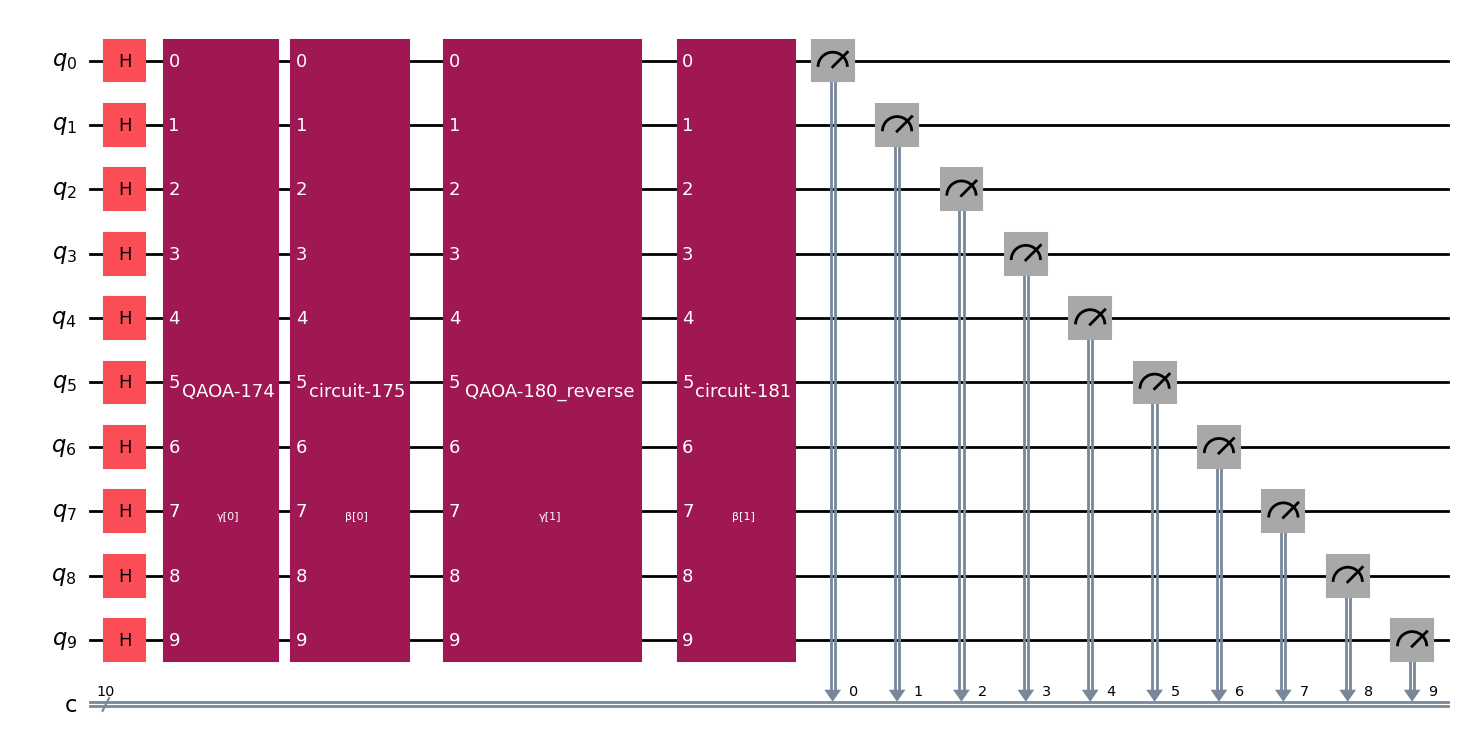

In [7]:
from qopt_best_practices.swap_strategies import create_qaoa_swap_circuit

theta = [1, 1, 0, 1]
# we define the edge_coloring map so that RZZGates are positioned next to SWAP gates to exploit CX cancellations
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(qaoa_hamiltonian.num_qubits)}

qaoa_circ = create_qaoa_swap_circuit(qaoa_hamiltonian, swap_strategy, edge_coloring, qaoa_layers=2)

qaoa_circ.draw("mpl")

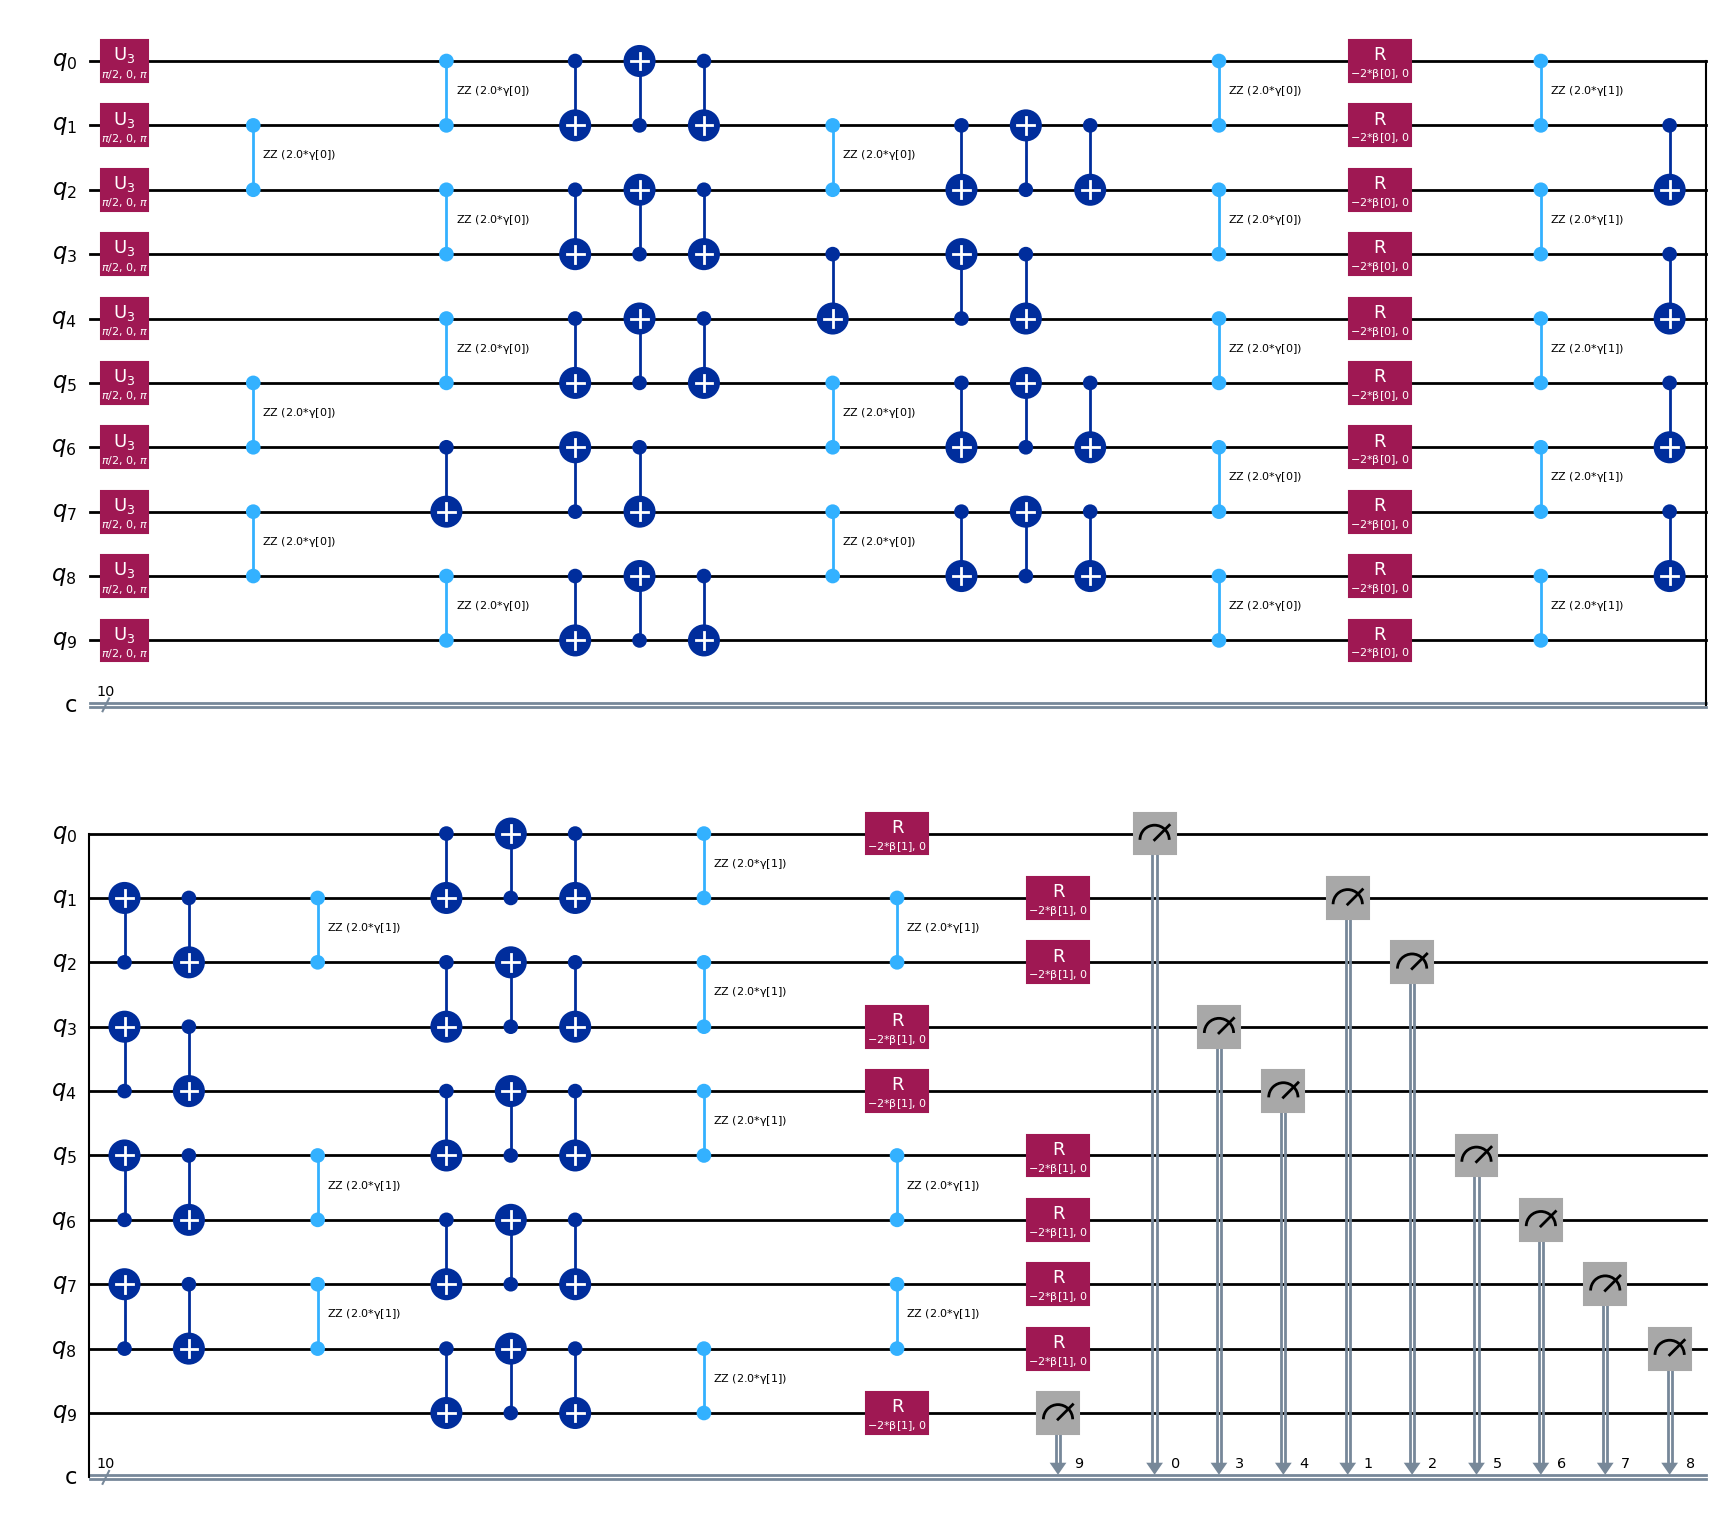

In [8]:
qaoa_circ.decompose(reps=2).draw("mpl")

## 5. Choose backend

This notebook currently runs on a **simulated fake backend**, using the **BackendSampler** from `qiskit`. To run on **real devices**, and make use of the error supression, mitigation and additional capabilities of **Qiskit Runtime**, you must uncomment the cell that uses the **runtime Sampler.**

It is important to remember to **skip transpilation** during our sampler execution, independently of the primitive being used.

In [9]:
# SIMULATED FAKE BACKEND --> BackendSampler

from qiskit_ibm_runtime.fake_provider import FakeGuadalupe
from qiskit.primitives import BackendSampler

backend = FakeGuadalupe()
sampler = BackendSampler(backend=backend, skip_transpilation=True)

In [10]:
## UNCOMMENT TO RUN ON:
## REAL BACKEND --> Sampler from qiskit_ibm_runtime

# from qiskit_ibm_runtime import Sampler, Options, QiskitRuntimeService

# service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.get_backend('Guadalupe')
# options = Options()
# options.transpiler.skip_transpilation = True

# sampler = Sampler(backend=backend, options=options)

## 6. Evaluate backend to define best initial layout

The `BackendEvaluator` util allows you to find the best subset of qubits of a given geometry according to a given metric. By default, it will try to find the **line** (geometry) witht the best **2-qubit gate fidelity** (metric). Check out the how-to on qubit subset finding to learn how to provide customized metric and geometry evaluation callables.

In [11]:
from qopt_best_practices.qubit_selection import BackendEvaluator

path_finder = BackendEvaluator(backend)

# the Backend Evaluator accepts custom subset definitions and metrics,
# but defaults to finding the line with the best fidelity
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)

Best path:  [1, 4, 7, 10, 12, 13, 14, 11, 8, 5]
Best path fidelity 0.9099375156097996
Num. evaluated paths 20


Define transpiler initial layout with best path:

In [12]:
from qiskit.transpiler import Layout

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0])  # needs qaoa_circ

## 7. Transpile circuit

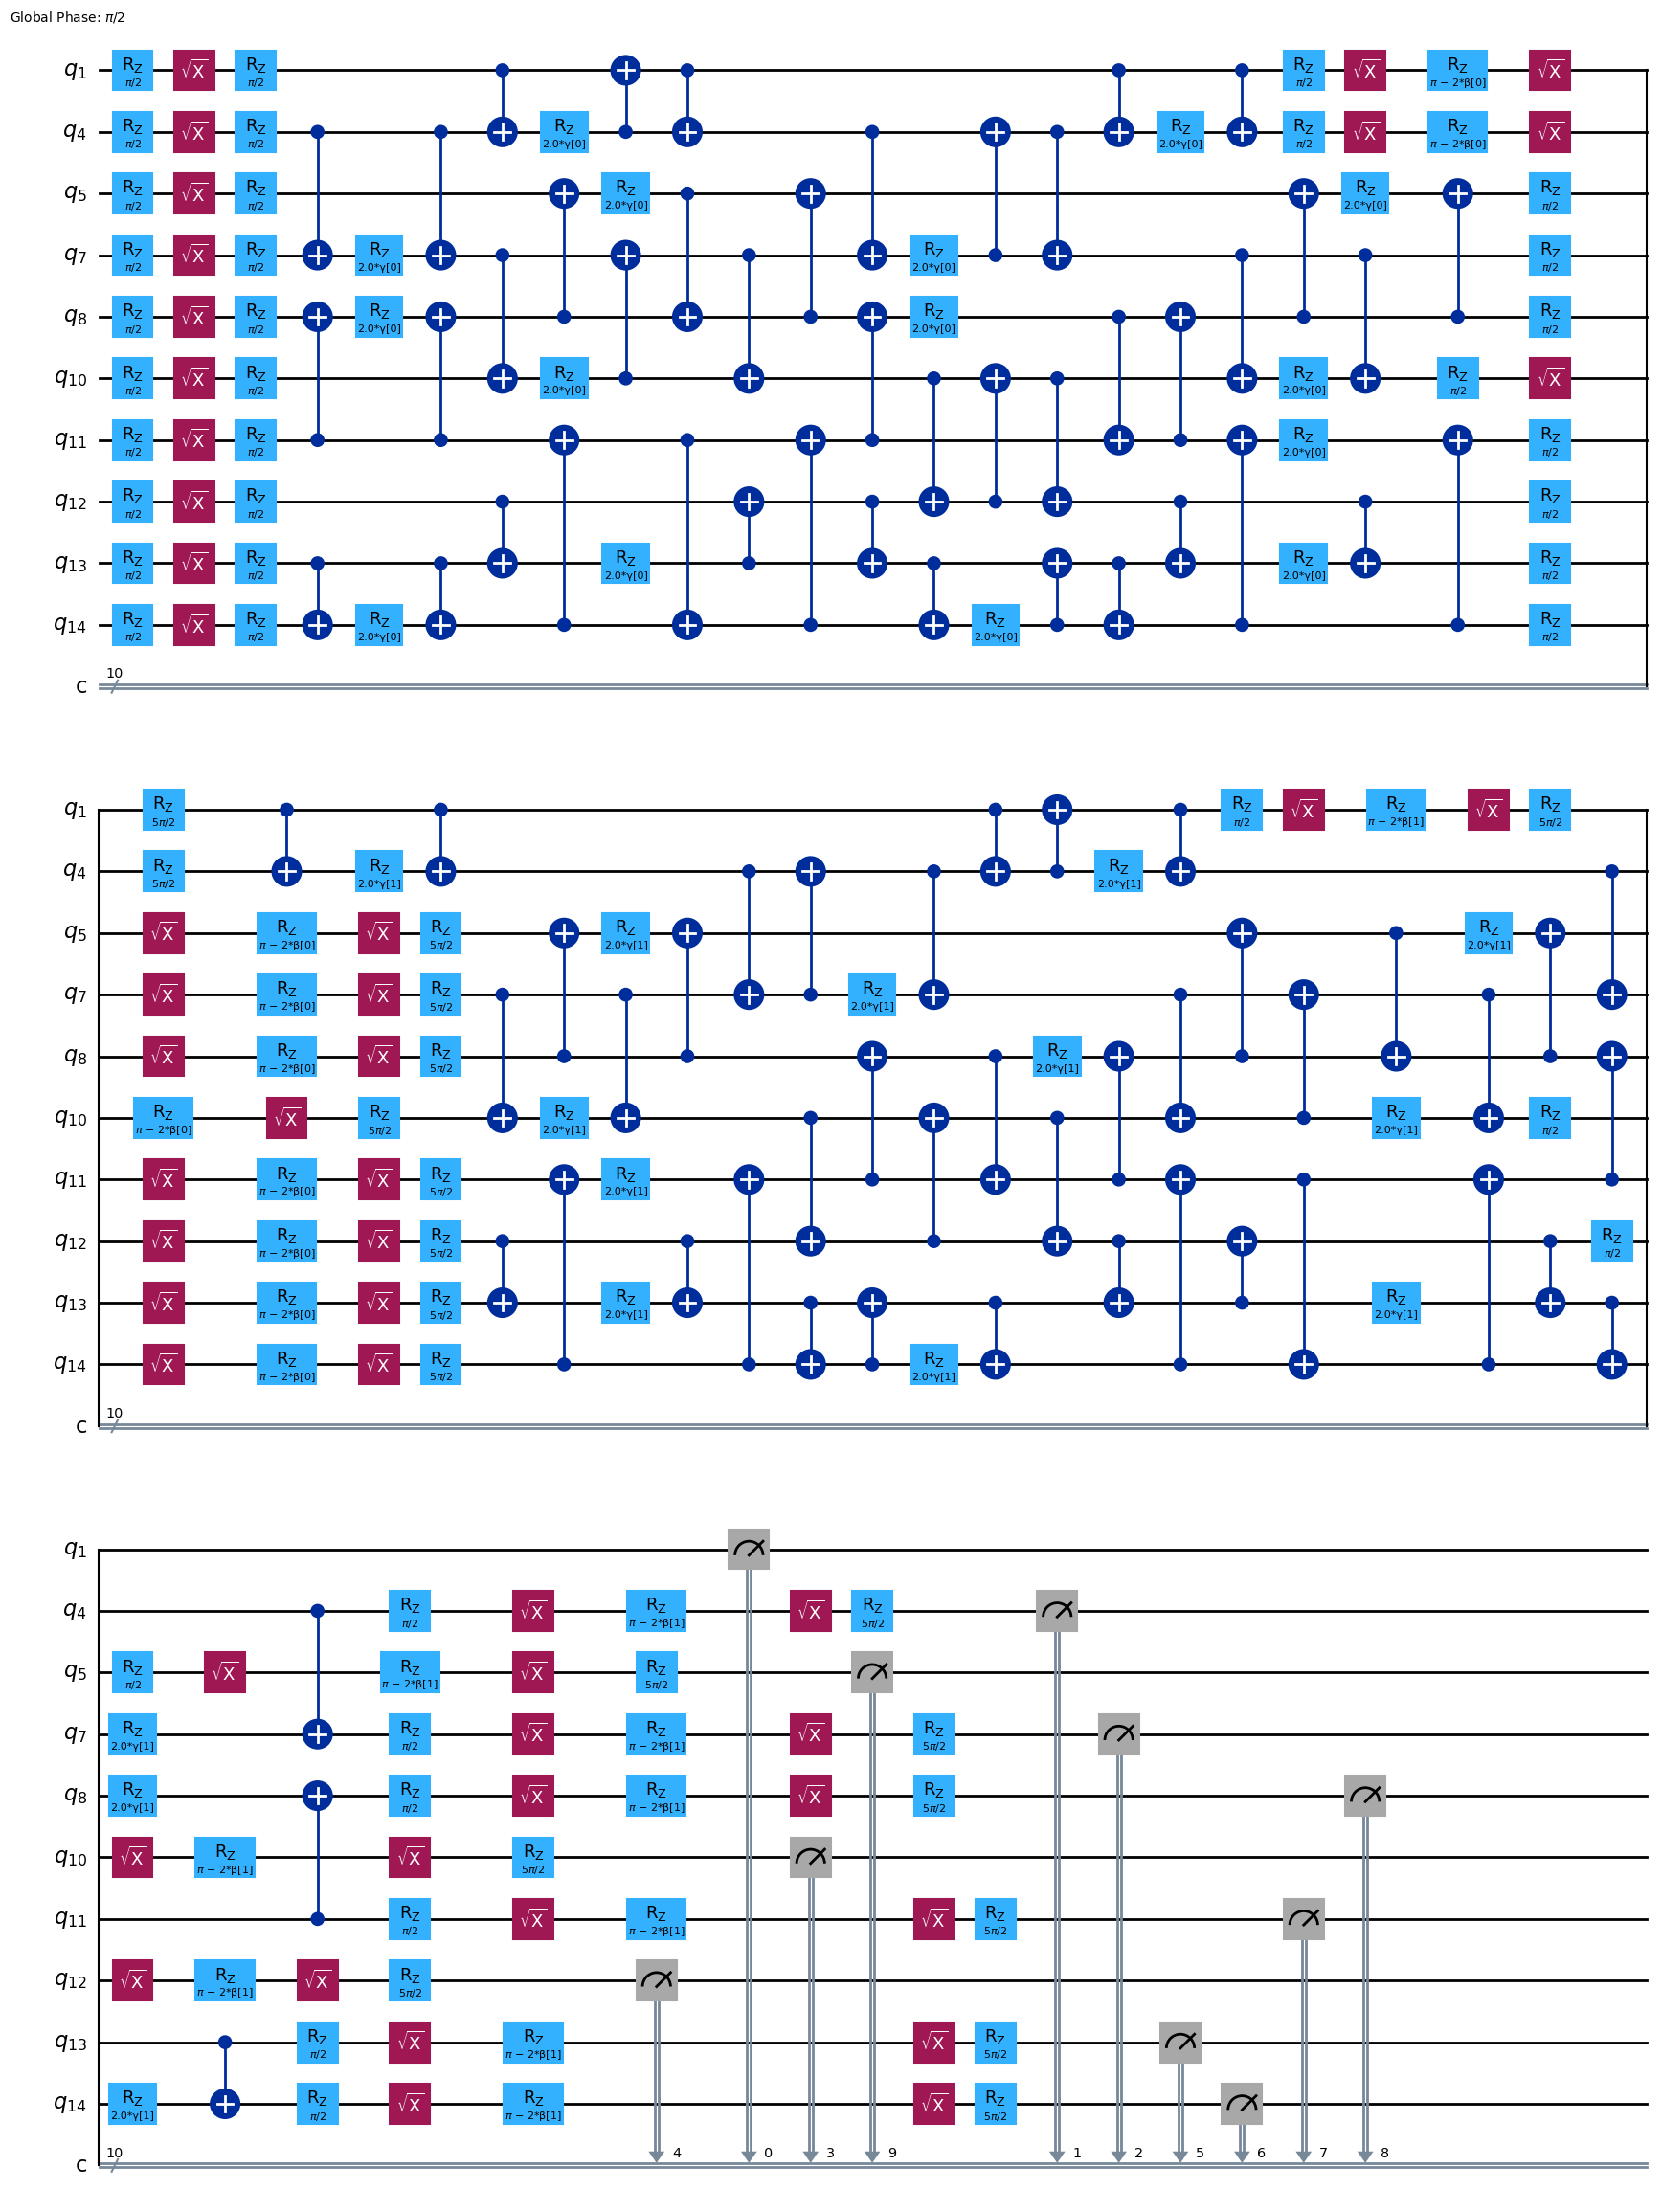

In [13]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)

from qiskit import transpile

basis_gates = ["rz", "sx", "x", "cx"]

backend_cmap = CouplingMap(backend.configuration().coupling_map)

pass_manager_post = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Map to initial_layout and finally enlarge with ancilla.
qaoa_circ = pass_manager_post.run(qaoa_circ)

# Now transpile to sx, rz, x, cx basis
qaoa_circ = transpile(qaoa_circ, basis_gates=basis_gates)
qaoa_circ.draw("mpl", idle_wires=False)

## 8. Define and run QAOA algorithm for the problem Hamiltonian, using the Sampler primitive and the QAOA ansatz

### 1. Define Cost Function

The QAOA cost function using the Sampler requires the manual computation of the expectation values from the measurement results. For this means, we use the `evaluate_sparse_pauli` helper function.

In [14]:
from qopt_best_practices.cost_function import evaluate_sparse_pauli


def cost_func_sampler(params, ansatz, hamiltonian, sampler):

    job = sampler.run(ansatz, params)
    sampler_result = job.result()
    sampled = sampler_result.quasi_dists[0]

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    result = sum(probability * value for probability, value in evaluated.values())

    return result

### 2. Define Initial Point

In this example, we use the TQA initialization technique [(Sack et al. 2021)](https://arxiv.org/abs/2101.05742) to define the initial point of the parameter optimization:

In [15]:
import numpy as np

# TQA initialization parameters
dt = 0.75
p = 2  # 2 qaoa layers
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))
print(init_params)

[0.8125 0.4375 0.1875 0.5625]


### 3. Run Optimization

We can plug our sampler-based cost function into the scipy minimizing routine to find our optimal parameters:

In [16]:
from scipy.optimize import minimize

result = minimize(
    cost_func_sampler,
    init_params,
    args=(qaoa_circ, qaoa_hamiltonian, sampler),
    method="COBYLA",
)
print(result)

/opt/anaconda3/envs/ibm_tech/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.984375
       x: [ 2.003e+00  2.443e-01  2.945e-01  5.651e-01]
    nfev: 45
   maxcv: 0.0


### 4. Sample best result

In [17]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


def sample_most_likely_bitstring(state_vector, num_bits):
    values = list(state_vector.values())
    most_likely = np.argmax(np.abs(values))
    most_likely_bitstring = to_bitstring(most_likely, num_bits)
    most_likely_bitstring.reverse()
    return np.asarray(most_likely_bitstring)

In [20]:
qc = qaoa_circ.assign_parameters(result.x)
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

best_result = sample_most_likely_bitstring(samp_dist, len(graph))
print(best_result)

[1 1 0 1 1 0 0 1 0 1]


### 5. Visualize best cut --> Problem solution

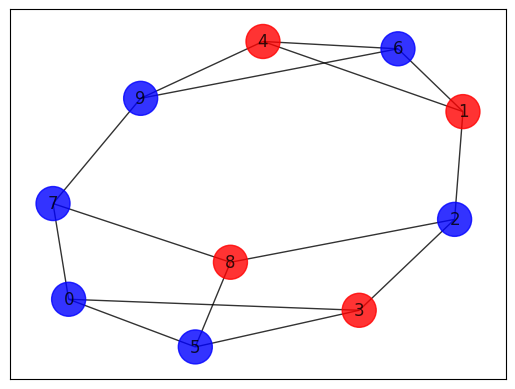

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["r" if i == 0 else "b" for i in x]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)

plot_result(graph, best_result)